In [878]:
import math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import os

import torch
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split

import torch.nn.functional as F
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim

------
## 1. Preprocessing of data: 

### 1. Audio Utilities:

In [974]:
class AudioUtil ():
    
    @staticmethod
    def open (audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr) 
    
    @staticmethod
    def spectro_gram (aud, n_mels = 16, n_fft = 1024, hop_len = 1024):
        sig, sr = aud
        top_db = 80
        spec = transforms.MelSpectrogram(sr,n_fft = n_fft, n_mels = n_mels, hop_length = hop_len)(sig)
        spec = transforms.AmplitudeToDB(top_db = top_db)(spec)
        return (spec)
    
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

### 2. Sound data set:

In [1025]:
class SoundDS (Dataset): 
    
    def __init__ (self, df, data_path):
        self.df = df
        self.data_path = str (data_path)
        self.sr = 48000
        
    def __len__ (self):        
        return (len(self.df))
        
    def __getitem__(self, idx):
        audio_file = self.data_path + self.df.loc[idx, "realtive_path"]
        class_id = torch.tensor(self.df.loc[idx, 'Y'], dtype = float)
        aud = AudioUtil.open(audio_file)
        sgram = AudioUtil.spectro_gram(aud,  n_fft=1024,n_mels=64, hop_len=1024)
        sgram_m, sgram_s = sgram.mean(), sgram.std()
        sgram = (sgram -  sgram_m)/sgram_s

        return sgram, class_id

------
## 1. Artificial Neural network (ANN): 

## 1. Model building: 

In [881]:
class regressionNN (nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(64*141, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
#         nn.ReLU(),
#          nn.Linear(265, 128),
#          nn.ReLU(),  
#          nn.Linear(128, 64),
          nn.ReLU(),    
          nn.Linear(64, 32),
          nn.ReLU(),  
           nn.Linear(32, 16),
          nn.ReLU(),    
          nn.Linear(16, 1)
        )
    
    def forward(self, x):
        x = x.view(-1,64*141) # reshape the input tensor
        return self.layers(x)

## 2. Preparing training data: 

In [1017]:
df = pd.read_csv("/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/Dataframes/LL_exp2.csv")
Labels = torch.tensor(df["Y"], dtype=float)
Labels_m, Labels_s = Labels.mean(), Labels.std()
df["Y"] = (Labels-Labels_m)/Labels_s
data_path=r'/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code'
myds = SoundDS(df, data_path)

In [977]:
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl =torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True)

In [1018]:
# In case you need to load training data. 
train_dll = torch.utils.data.DataLoader(myds, batch_size=len(myds), shuffle=True)
training = []
for k, (i , j) in enumerate (train_dll):
    for l in i: 
        training.append(l)
    if k == num_train:
        break


In [966]:
num_val

750

## 3. Model employment: 

In [967]:
exp4model = regressionNN()
criterion = nn.MSELoss()
weight_decay = 5e-5
optimizer = optim.Adam(exp4model.parameters(),lr = 0.00001, weight_decay = weight_decay)

In [968]:
#list(exp4model.layers[4].parameters())

In [969]:
epoch = 0
num_epochs = 100
losses = []
val_losses = []
pbar = tqdm(total=num_epochs)

while epoch < num_epochs: 
    
    epoch += 1
    steps = list(enumerate(train_dl))
    current_loss = 0.0
    for i, (x_batch, y_batch) in steps: 
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        y_batch_pred = exp4model(x_batch)
        loss = criterion(y_batch_pred.view(-1,len(y_batch)),y_batch.view(-1,len(y_batch)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss1, current = loss.item(), (i+1)*len(x_batch)
        losses.append(loss1)
    for x_batch1, y_batch1 in val_dl:
        x_batch1 = x_batch1.float()
        y_batch1 = y_batch1.float()
        y_batch1_pred = exp4model(x_batch1)
        loss1 = criterion(y_batch1_pred.view(-1,len(y_batch1)),y_batch1.view(-1,len(y_batch1)))
        val_losses.append(loss1)
    pbar.update(1)


  0%|          | 0/100 [00:00<?, ?it/s]

In [970]:
losses[-1]

0.00047852753777988255

--------

### 4. Saving the model: 

In [971]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp4"
paratosave = {"model_state": exp4model.state_dict(), "optimizer_state":optimizer.state_dict(),"train_losses":losses,\
             "valid_losses":val_losses, "num_epoch": num_epochs }
torch.save(paratosave, os.path.join(path,f"exp4_{weight_decay}_best.pth"))

In [978]:
weight_decay1 = [1, 1e-1, 1e-2, 1e-3,1e-4,1e-5,1e-6]
for i in range (len(weight_decay1)): 
    exp4model = regressionNN()
    criterion = nn.MSELoss()
    weight_decay = weight_decay1[i]
    optimizer = optim.Adam(exp4model.parameters(),lr = 0.00001, weight_decay = weight_decay)
    epoch = 0
    num_epochs = 100
    losses = []
    val_losses = []
    pbar = tqdm(total=num_epochs)

    while epoch < num_epochs: 

        epoch += 1
        steps = list(enumerate(train_dl))
        current_loss = 0.0
        for i, (x_batch, y_batch) in steps: 
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            y_batch_pred = exp4model(x_batch)
            loss = criterion(y_batch_pred.view(-1,len(y_batch)),y_batch.view(-1,len(y_batch)))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss1, current = loss.item(), (i+1)*len(x_batch)
            losses.append(loss1)
        for x_batch1, y_batch1 in val_dl:
            x_batch1 = x_batch1.float()
            y_batch1 = y_batch1.float()
            y_batch1_pred = exp4model(x_batch1)
            loss1 = criterion(y_batch1_pred.view(-1,len(y_batch1)),y_batch1.view(-1,len(y_batch1)))
            val_losses.append(loss1)
        pbar.update(1)
    path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp4/Shuffeled"
    paratosave = {"model_state": exp4model.state_dict(), "optimizer_state":optimizer.state_dict(),"train_losses":losses,\
         "valid_losses":val_losses, "num_epoch": num_epochs }
    torch.save(paratosave, os.path.join(path,f"exp4_{weight_decay}_best.pth"))

    
    

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

-----------

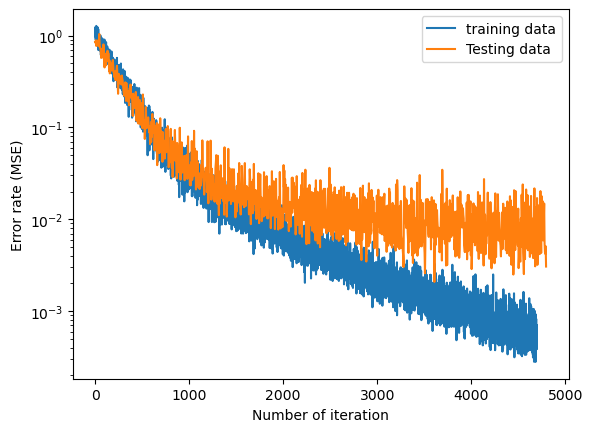

In [973]:
with torch.no_grad():
    plt.plot(losses, label = "training data")
    plt.plot(np.arange(len(val_losses))*num_train/num_val,val_losses, label = "Testing data")
    plt.yscale("log")
    plt.ylabel("Error rate (MSE)")
    plt.xlabel("Number of iteration")
    plt.legend()

## 5. Checking the resulted data (training data set): 

### 1. Plot the histogram

In [1011]:
steps = list(enumerate(train_dl))
a1 = np.array([])
a1targets = np.array([])
for i, (x_batch, y_batch) in steps: 
    x1 = exp4model(x_batch)*Labels_s + Labels_m
    with torch.no_grad():
        a1 = np.append(a1,x1.numpy())
        a1targets = np.append(a1targets,y_batch.numpy())
                

In [1012]:
possible = set(a1targets)

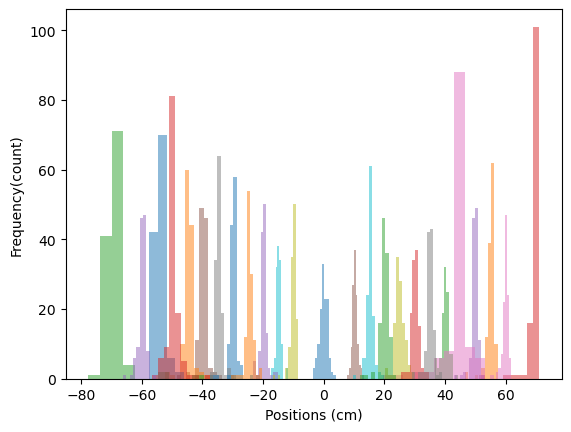

In [1013]:
for p in possible:
    plt.hist(a1[a1targets==p], alpha=0.5, label=f'{p}')
    plt.xlabel("Positions (cm)")
    plt.ylabel("Frequency(count)")

    
#plt.legend()

### 2. Plot the spectogram:

Text(0.5, 0, 'Time (second)')

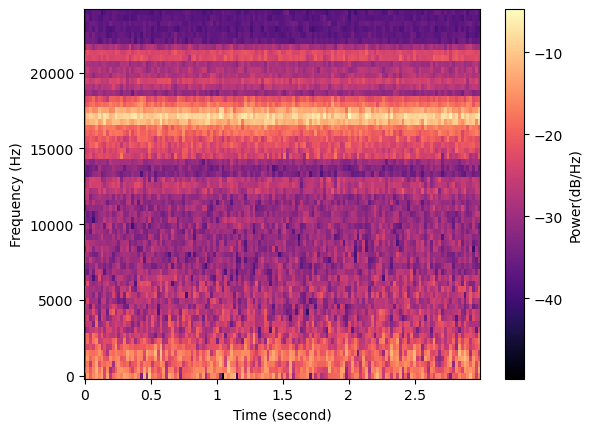

In [1024]:
#img = librosa.display.specshow(np.array(training[749][0]), sr = 48000,hop_length=1024, x_axis = "linear")
librosa.display.specshow(np.array(training[500][0]), sr = 48000,hop_length=1024, y_axis = "linear",x_axis='time')
plt.colorbar(label= "Power(dB/Hz)")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (second)")


### 3. Find mean and std of each value:  

In [990]:
possible1 = list(possible)
possible1.sort()
print(possible1)

[-1.7025378434799217, -1.4593181515542184, -1.337708305591367, -1.2160984596285154, -1.094488613665664, -0.9728787677028123, -0.8512689217399608, -0.7296590757771092, -0.6080492298142577, -0.48643938385140617, -0.3648295378885546, -0.24321969192570309, 0.0, 0.24321969192570309, 0.3648295378885546, 0.48643938385140617, 0.6080492298142577, 0.7296590757771092, 0.8512689217399608, 0.9728787677028123, 1.094488613665664, 1.2160984596285154, 1.337708305591367, 1.4593181515542184, 1.7025378434799217]


In [991]:
values_class = []
for p in possible1:
    values_class.append(a1[a1targets==p])

In [992]:
values = [-70,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,0,10,15,20,25,30,35,40,45,50,55,60,70]
for i in range (25): 
    print (f"Thes mean of {[values[i]]} is {values_class[i].mean()} and std is {values_class[i].std()}")

Thes mean of [-70] is -69.84029757181803 and std is 1.3353756128998284
Thes mean of [-60] is -59.89076335490251 and std is 1.2632177225177514
Thes mean of [-55] is -54.84359122104332 and std is 1.2146886492477298
Thes mean of [-50] is -50.113763193930346 and std is 1.3105380727178295
Thes mean of [-45] is -45.0334470195155 and std is 1.4816920768408577
Thes mean of [-40] is -39.9947128959324 and std is 1.2563774037263615
Thes mean of [-35] is -35.175047491479106 and std is 1.1525737480726324
Thes mean of [-30] is -30.32493074928842 and std is 1.1525329930833121
Thes mean of [-25] is -25.42429841083029 and std is 1.0895193127429854
Thes mean of [-20] is -20.362058188971574 and std is 1.0911877504672403
Thes mean of [-15] is -15.348006788150284 and std is 1.0377711657579463
Thes mean of [-10] is -10.296766618202472 and std is 0.9593336345926965
Thes mean of [0] is -0.0730401793656152 and std is 1.149209286237044
Thes mean of [10] is 10.048851822604652 and std is 0.9255706290858681
Thes m

In [993]:
means = []
stds = []
values = [-70,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,0,10,15,20,25,30,35,40,45,50,55,60,70]
for i in range (25): 
    means.append(values_class[i].mean())
    stds.append(values_class[i].std())

Text(0, 0.5, 'Mean of the predicted values (cm)')

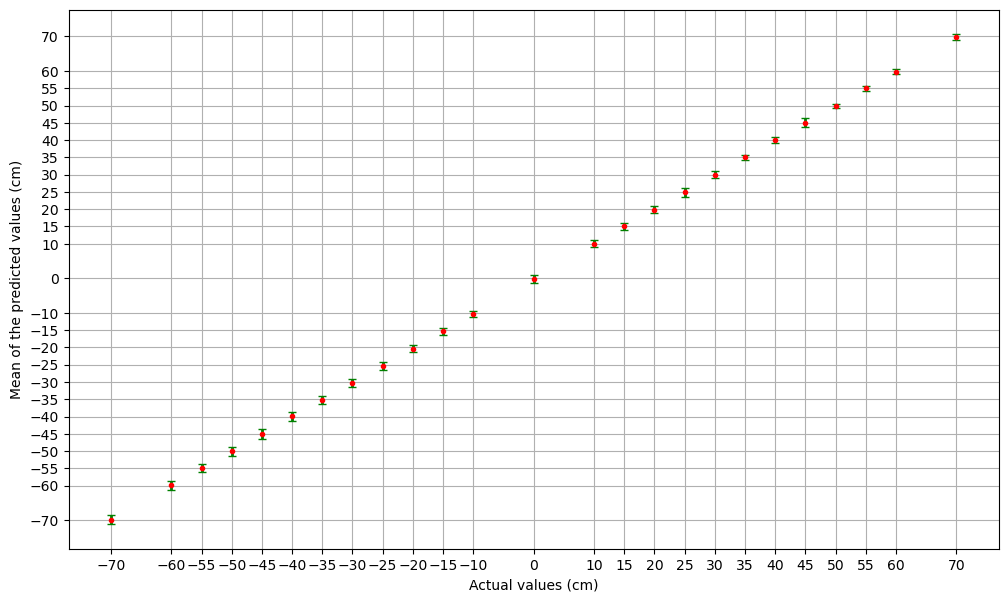

In [994]:
plt.figure(figsize = (12,7))
plt.errorbar(values,means, yerr = stds,fmt=".", color='red',
             ecolor='green', elinewidth=2, capsize=3)
plt.xticks(np.array(values))
plt.yticks(np.array(values))
plt.grid()
plt.xlabel("Actual values (cm)")
plt.ylabel ("Mean of the predicted values (cm)")



In [995]:
#Maximum difference in a mean
index_max_mean = (np.array(means)-np.array(values)).argmax()
print(f"Maximum difference in a mean is {values[index_max_mean]-means[index_max_mean]} for a value of {values[index_max_mean]}")
#Maximum difference in an std
print(f"Maximum difference in an std is {stds[np.array(stds).argmax()]} for a value of {values[np.array(stds).argmax()]}")

Maximum difference in a mean is -0.15970242818197278 for a value of -70
Maximum difference in an std is 1.4816920768408577 for a value of -45


In [996]:
values = np.array([-70,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,0,10,15,20,25,30,35,40,45,50,55,60,70])
errors = np.array([])
for i in range (len(values)): 
    with torch.no_grad():
        error = values[i] - values_class[i]
        errors = np.append(errors,error)
errors.std()

1.0928750731107073

### 5. Loading the model: 

In [1009]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp4/Shuffeled"
loaded_parameters = torch.load(os.path.join(path,f"exp4_{5e-05}_best.pth"))

In [1010]:
exp4model = regressionNN()
exp4model.load_state_dict(loaded_parameters["model_state"])

<All keys matched successfully>

In [670]:
loaded_parameters

{'model_state': OrderedDict([('layers.0.weight',
               tensor([[-2.6725e-03,  8.2986e-03, -2.9032e-03,  ...,  1.3993e-03,
                        -4.4937e-03, -6.1711e-03],
                       [ 1.1368e-04,  2.4591e-05, -1.4748e-03,  ...,  2.1970e-04,
                         1.3632e-04,  9.8231e-05],
                       [-5.3987e-04, -8.9461e-03, -8.6224e-03,  ..., -6.8391e-03,
                        -3.7025e-03, -1.4019e-03],
                       ...,
                       [ 5.5445e-03,  3.7666e-03,  1.0770e-02,  ..., -5.7453e-03,
                         6.4072e-03, -4.6656e-03],
                       [-4.8993e-03, -8.0870e-04, -1.9853e-03,  ..., -9.7697e-03,
                         8.5884e-03, -7.0591e-03],
                       [ 9.7426e-03,  8.0272e-03, -1.8048e-03,  ...,  2.7670e-03,
                         2.2628e-03, -6.4297e-03]])),
              ('layers.0.bias',
               tensor([-6.0431e-03, -1.0037e-05, -7.4589e-03,  5.0701e-03,  4.6945e-03,
  

In [704]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp4"
loaded_parameters1 = torch.load(os.path.join(path,"exp4_1_best.pth"))

In [705]:
loaded_parameters1

{'model_state': OrderedDict([('layers.0.weight',
               tensor([[-3.1034e-05,  3.1637e-04,  2.3496e-04,  ...,  1.7232e-04,
                         1.6020e-04,  1.9595e-04],
                       [ 1.0920e-04, -4.0536e-04, -2.1665e-04,  ..., -9.0169e-04,
                        -8.6317e-04, -9.5259e-04],
                       [-8.3795e-05,  2.6868e-04,  2.8816e-04,  ..., -6.3017e-04,
                        -6.2236e-04, -6.3484e-04],
                       ...,
                       [-1.0893e-04,  4.7632e-04,  3.4221e-04,  ...,  3.0523e-04,
                         2.8104e-04,  3.4006e-04],
                       [-5.7600e-05,  4.0064e-04,  2.9400e-04,  ...,  2.6948e-04,
                         2.4933e-04,  2.9624e-04],
                       [-2.0146e-04,  9.6221e-04,  6.9442e-04,  ...,  6.9548e-04,
                         6.4929e-04,  7.6891e-04]])),
              ('layers.0.bias',
               tensor([ 7.5002e-05,  1.3603e-04,  3.3277e-04,  4.9934e-04,  4.7449e-05,
  

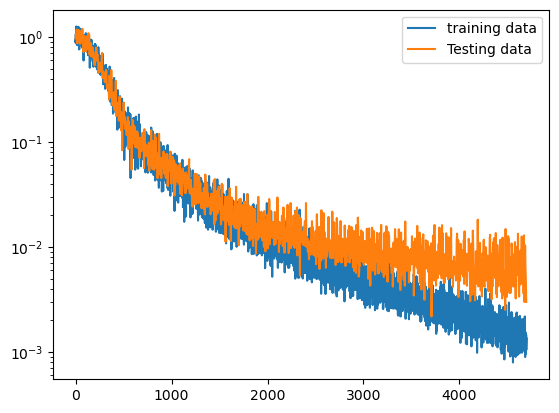

In [674]:
with torch.no_grad():
    plt.plot(loaded_parameters["train_losses"], label = "training data")
    plt.plot(np.arange(len(loaded_parameters["valid_losses"]))*len(loaded_parameters["train_losses"])/len(loaded_parameters["valid_losses"]),loaded_parameters["valid_losses"], label = "Testing data")
    plt.yscale("log")
    plt.legend()

In [ ]:
#lengths of different values 
lengths = []
for i in range(25):
    lengths.append(len(values_class[i]))
np.average(lengths)

----------
## 6. Checking the resulted data (Valid data set): 

### 1. Plot the histogram

In [997]:
a1 = np.array([])
a1targets = np.array([])
for x_batch, y_batch in val_dl: 
    x1 = exp4model(x_batch)*Labels_s + Labels_m
    with torch.no_grad():
        a1 = np.append(a1,x1.numpy())
        a1targets = np.append(a1targets,y_batch.numpy())
                

In [998]:
possible = set(a1targets)

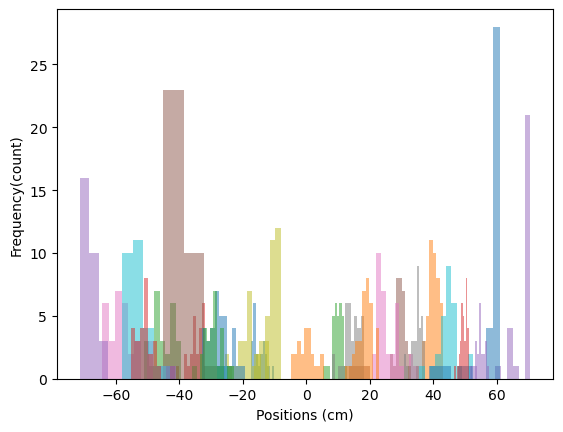

In [999]:
for p in possible:
    plt.hist(a1[a1targets==p], alpha=0.5, label=f'{p}')
    plt.xlabel("Positions (cm)")
    plt.ylabel("Frequency(count)")

#plt.legend()

In [1000]:
with torch.no_grad():
    d = a1
    y = a1targets*Labels_s.numpy() + Labels_m.numpy()
    sum1 = ((d-y)**2).sum()/len(d)
    print(sum1)

17.759999372899912


In [1001]:
possible1 = list(possible)
possible1.sort()
print(possible1)

[-1.7025378434799217, -1.4593181515542184, -1.337708305591367, -1.2160984596285154, -1.094488613665664, -0.9728787677028123, -0.8512689217399608, -0.7296590757771092, -0.6080492298142577, -0.48643938385140617, -0.3648295378885546, -0.24321969192570309, 0.0, 0.24321969192570309, 0.3648295378885546, 0.48643938385140617, 0.6080492298142577, 0.7296590757771092, 0.8512689217399608, 0.9728787677028123, 1.094488613665664, 1.2160984596285154, 1.337708305591367, 1.4593181515542184, 1.7025378434799217]


In [1002]:
values_class = []
for p in possible1:
    values_class.append(a1[a1targets==p])

In [1003]:
values = [-70,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,0,10,15,20,25,30,35,40,45,50,55,60,70]
for i in range (25): 
    print (f"Thes mean of {[values[i]]} is {values_class[i].mean()} and std is {values_class[i].std()}")

Thes mean of [-70] is -67.06720403035482 and std is 5.257557263400422
Thes mean of [-60] is -57.456770866147934 and std is 4.890786230094011
Thes mean of [-55] is -52.08594267708914 and std is 6.207982107831479
Thes mean of [-50] is -50.72809410095215 and std is 2.901899297689031
Thes mean of [-45] is -44.726498530461235 and std is 3.7191486949571817
Thes mean of [-40] is -37.659558813912525 and std is 10.38483428276473
Thes mean of [-35] is -34.53488051373026 and std is 2.254943958616405
Thes mean of [-30] is -29.307011357060187 and std is 2.5583813506274486
Thes mean of [-25] is -27.2542962210519 and std is 3.2413516225576773
Thes mean of [-20] is -18.352599890335746 and std is 3.6993558005276714
Thes mean of [-15] is -14.84236276717413 and std is 1.90918205883852
Thes mean of [-10] is -11.208874954896814 and std is 3.107948172312998
Thes mean of [0] is 0.018778101257655933 and std is 2.6579332693762194
Thes mean of [10] is 9.794608808332875 and std is 1.6343794037609833
Thes mean of

In [1004]:
means = []
stds = []
values = [-70,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,0,10,15,20,25,30,35,40,45,50,55,60,70]
for i in range (25): 
    means.append(values_class[i].mean())
    stds.append(values_class[i].std())

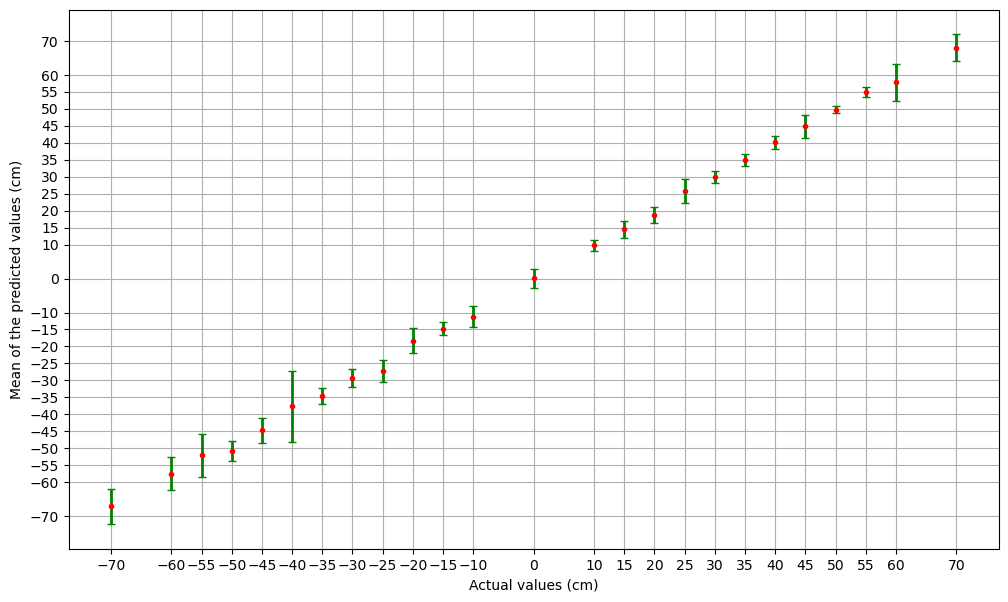

In [1005]:
plt.figure(figsize = (12,7))
plt.errorbar(values,means, yerr = stds,fmt=".", color='red',
             ecolor='green', elinewidth=2, capsize=3)
plt.xticks(np.array(values))
plt.yticks(np.array(values))
plt.xlabel("Actual values (cm)")
plt.ylabel ("Mean of the predicted values (cm)")
plt.grid()


In [1006]:
#Maximum difference in a mean
index_max_mean = (np.array(means)-np.array(values)).argmax()
print(f"Maximum difference in a mean is {values[index_max_mean]-means[index_max_mean]} for a value of {values[index_max_mean]}")
#Maximum difference in an std
print(f"Maximum difference in an std is {stds[np.array(stds).argmax()]} for a value of {values[np.array(stds).argmax()]}")

Maximum difference in a mean is -2.932795969645184 for a value of -70
Maximum difference in an std is 10.38483428276473 for a value of -40


In [1007]:
np.array(means)-np.array(values)

array([ 2.93279597,  2.54322913,  2.91405732, -0.7280941 ,  0.27350147,
        2.34044119,  0.46511949,  0.69298864, -2.25429622,  1.64740011,
        0.15763723, -1.20887495,  0.0187781 , -0.20539119, -0.54086237,
       -1.34838611,  0.70630102, -0.1164971 , -0.11335844,  0.06111162,
       -0.19867254, -0.3209099 , -0.11701184, -2.14870195, -2.06443337])

In [1008]:
#lengths of different values 
lengths = []
for i in range(25):
    lengths.append(len(values_class[i]))
np.average(lengths)

30.0

In [920]:
values = np.array([-70,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,0,10,15,20,25,30,35,40,45,50,55,60,70])
errors = np.array([])
for i in range (len(values)): 
    with torch.no_grad():
        error = values[i] - values_class[i]
        errors = np.append(errors,error)
errors.std()

2.8000083417934207

-------
## Regularization Plot:

In [979]:
train_losse = []
valid_losse = []
x = [1,1e-1, 1e-2, 1e-3,1e-4,5e-5,1e-5,1e-6]

In [980]:
path = "/Users/mohammeda.salha/Desktop/MISCADA/The final project/The code/The saved models/Exp4/Shuffeled"
for i in x: 
    loaded_parameters = torch.load(os.path.join(path,f"exp4_{i}_best.pth"))
    with torch.no_grad():
        train_losse.append(loaded_parameters["train_losses"][-1])
        valid_losse.append(loaded_parameters["valid_losses"][-1])


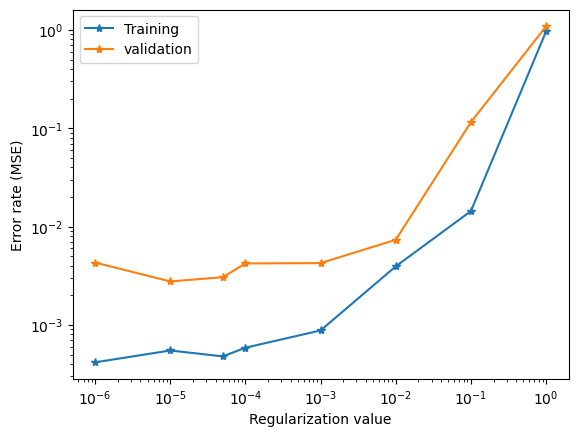

In [981]:
x = [1, 1e-1, 1e-2, 1e-3,1e-4,5e-5,1e-5,1e-6]
with torch.no_grad():
    plt.plot(x,train_losse, label = "Training", marker='*')
    plt.plot(x,valid_losse, label = "validation",marker='*' )
    plt.ylabel("Error rate (MSE)")
    plt.xlabel("Regularization value")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
